In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
# 数据集名称 -- <url,sha-1密钥>
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
import numpy as np
import pandas as pd
import torch
import os
os.environ ["KMP_DUPLICATE_LIB_OK"] ="TRUE"
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
# 1460个数据 80个特征 1个label
print(train_data.shape) 
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [9]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [10]:
# 第一列id对训练没有帮助，进行删除操作
# 将train_data数据集第二列与最后一列、训练数据集第二列开始合并
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.iloc[0:4,[0,1,2,3,-2,-1]])

   MSSubClass MSZoning  LotFrontage  LotArea SaleType SaleCondition
0          60       RL         65.0     8450       WD        Normal
1          20       RL         80.0     9600       WD        Normal
2          60       RL         68.0    11250       WD        Normal
3          70       RL         60.0     9550       WD       Abnorml


In [12]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
# 找到不是字符串的列 nan也会包含进去 算均值的时候会被去掉
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 标准化方法 其缩放到均值为0，标准差为1的区间
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0 fillna(0)不会对原始数据修改
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features.iloc[0:4,[0,1,2,3,-2,-1]])

   MSSubClass MSZoning  LotFrontage   LotArea SaleType SaleCondition
0    0.067320       RL    -0.202033 -0.217841       WD        Normal
1   -0.873466       RL     0.501785 -0.072032       WD        Normal
2    0.067320       RL    -0.061269  0.137173       WD        Normal
3    0.302516       RL    -0.436639 -0.078371       WD       Abnorml


In [13]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
print(all_features.shape)
# 将分类变量转换为one-hot变量，比如一列有5类（nan也算单独一种）00001为其中一种
all_features = pd.get_dummies(all_features, dummy_na=True)

(2919, 79)


,MSSubClass,LotFrontage,LotArea,SaleCondition_nan
0,0.067320,-0.202033,-0.217841,0
1,-0.873466,0.501785,-0.072032,0
2,0.067320,-0.061269,0.137173,0
3,0.302516,-0.436639,-0.078371,0


In [15]:
# 样本数量
n_train = train_data.shape[0]
# 拿出来train_data 转换为tensor对象
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# labels
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [16]:
loss = nn.MSELoss()
# 特征数
in_features = train_features.shape[1]
# 简单的线性函数
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [17]:
# 对数的均方误差
def log_rmse(net, features, labels):
   # 限定值在 1-inf之间 避免出现负数
   clipped_preds = torch.clamp(net(features), 1, float('inf'))
   rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
   return rmse.item()

In [18]:
# admin优化器
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # train_ls 均方损失误差
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [19]:
# 数据划分为k个子集，k-1作为训练集
# i当前作为验证集的索引(0-k-1) X特征向量集 y目标变量
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            # 如果当前子集索引j等于i x_part 和 y_part作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            # 否则将其添加到训练集
            X_train, y_train = X_part, y_part
        else:
            # 不为空直接连接到训练集中
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    #返回训练集 和 验证集
    return X_train, y_train, X_valid, y_valid

In [25]:

# k折交叉验证流程
# 折叠次数 训练集 目标训练集 迭代次数 学习率 权重衰减参数 批次大小
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    # 累计训练和验证的 log RMSE的值
    train_l_sum, valid_l_sum = 0, 0
    
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        # 如果是第一个折叠 绘制log RMSE曲线
        # if i == 0:
        #     d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
        #              xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
        #              legend=['train', 'valid'], yscale='log')
        # print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
        #       f'验证log rmse{float(valid_ls[-1]):f}')
    # 计算平均训练和验证的 log RMSE值并返回
    return train_l_sum / k, valid_l_sum / k

5-折验证: 平均训练log rmse: 0.165797, 平均验证log rmse: 0.170634
2-折验证: 平均训练log rmse: 0.193844, 平均验证log rmse: 0.199431
3-折验证: 平均训练log rmse: 0.168200, 平均验证log rmse: 0.171632
4-折验证: 平均训练log rmse: 0.165794, 平均验证log rmse: 0.170843
5-折验证: 平均训练log rmse: 0.165398, 平均验证log rmse: 0.170884
6-折验证: 平均训练log rmse: 0.165449, 平均验证log rmse: 0.169135
7-折验证: 平均训练log rmse: 0.165341, 平均验证log rmse: 0.169676
8-折验证: 平均训练log rmse: 0.165051, 平均验证log rmse: 0.170750
9-折验证: 平均训练log rmse: 0.165405, 平均验证log rmse: 0.169272
10-折验证: 平均训练log rmse: 0.164650, 平均验证log rmse: 0.167669
11-折验证: 平均训练log rmse: 0.164048, 平均验证log rmse: 0.169088
12-折验证: 平均训练log rmse: 0.164026, 平均验证log rmse: 0.167987
13-折验证: 平均训练log rmse: 0.164449, 平均验证log rmse: 0.169262
14-折验证: 平均训练log rmse: 0.164902, 平均验证log rmse: 0.169114
15-折验证: 平均训练log rmse: 0.164483, 平均验证log rmse: 0.168808
16-折验证: 平均训练log rmse: 0.164173, 平均验证log rmse: 0.168609
17-折验证: 平均训练log rmse: 0.163787, 平均验证log rmse: 0.167845
18-折验证: 平均训练log rmse: 0.163877, 平均验证log rmse: 0.167496
19-折验证: 平均训练log rms

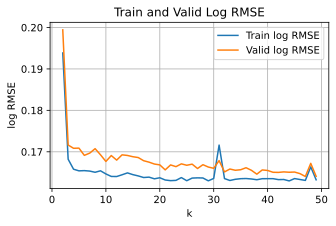

In [29]:
# 学习率设在20-40之间损失最小
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

train_l_list, valid_l_list = [train_l], [valid_l]



for k in range(2,50):
    num_epochs, lr, weight_decay, batch_size = 100, 5, 0, 64
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    
    train_l_list.append(train_l)
    valid_l_list.append(valid_l)  
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

d2l.plt.figure(figsize=(5, 3))
d2l.plt.plot(range(2, 50), train_l_list[1:], label='Train log RMSE')
d2l.plt.plot(range(2, 50), valid_l_list[1:], label='Valid log RMSE')
d2l.plt.xlabel('k')
d2l.plt.ylabel('log RMSE')
d2l.plt.legend()
d2l.plt.title('Train and Valid Log RMSE')
d2l.plt.grid(True)
d2l.plt.show()



#print(f'k的值为{k}时，平均训练log rmse{float(train_l):f},平均验证log rmse：{float(valid_l):f}最小')



5-折验证: 平均训练log rmse: 0.362448, 平均验证log rmse: 0.365861
5-折验证: 平均训练log rmse: 0.200928, 平均验证log rmse: 0.204238
5-折验证: 平均训练log rmse: 0.169193, 平均验证log rmse: 0.172693
5-折验证: 平均训练log rmse: 0.165799, 平均验证log rmse: 0.170749
5-折验证: 平均训练log rmse: 0.163456, 平均验证log rmse: 0.170423
5-折验证: 平均训练log rmse: 0.159632, 平均验证log rmse: 0.167372
5-折验证: 平均训练log rmse: 0.153685, 平均验证log rmse: 0.162971
5-折验证: 平均训练log rmse: 0.149380, 平均验证log rmse: 0.159175
5-折验证: 平均训练log rmse: 0.145413, 平均验证log rmse: 0.155967
5-折验证: 平均训练log rmse: 0.142287, 平均验证log rmse: 0.153557
5-折验证: 平均训练log rmse: 0.140123, 平均验证log rmse: 0.152021
5-折验证: 平均训练log rmse: 0.138423, 平均验证log rmse: 0.150961
5-折验证: 平均训练log rmse: 0.136438, 平均验证log rmse: 0.149926
5-折验证: 平均训练log rmse: 0.135077, 平均验证log rmse: 0.148907
5-折验证: 平均训练log rmse: 0.133810, 平均验证log rmse: 0.148713
5-折验证: 平均训练log rmse: 0.132868, 平均验证log rmse: 0.148628
5-折验证: 平均训练log rmse: 0.131394, 平均验证log rmse: 0.147759
5-折验证: 平均训练log rmse: 0.130802, 平均验证log rmse: 0.147951


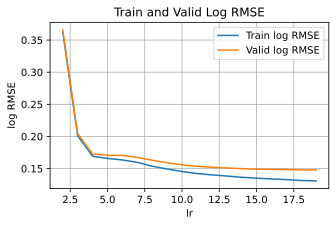

In [35]:
# k, num_epochs, lr, weight_decay, batch_size = 200, 100, 5, 0, 64
# train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
#                           weight_decay, batch_size)
# print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
#       f'平均验证log rmse: {float(valid_l):f}')

train_l_list.clear()
valid_l_list.clear()

for lr in range(2,20,1):
    k,num_epochs,  weight_decay, batch_size = 5,100, 0, 64
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    
    train_l_list.append(train_l)
    valid_l_list.append(valid_l)  
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

d2l.plt.figure(figsize=(5, 3))
d2l.plt.plot(range(2,20), train_l_list[0:], label='Train log RMSE')
d2l.plt.plot(range(2,20), valid_l_list[0:], label='Valid log RMSE')
d2l.plt.xlabel('lr')
d2l.plt.ylabel('log RMSE')
d2l.plt.legend()
d2l.plt.title('Train and Valid Log RMSE')
d2l.plt.grid(True)
d2l.plt.show()


5-折验证: 平均训练log rmse: 0.362586, 平均验证log rmse: 0.365766
5-折验证: 平均训练log rmse: 0.200686, 平均验证log rmse: 0.203796
5-折验证: 平均训练log rmse: 0.169297, 平均验证log rmse: 0.172892
5-折验证: 平均训练log rmse: 0.165420, 平均验证log rmse: 0.170728
5-折验证: 平均训练log rmse: 0.163531, 平均验证log rmse: 0.171225
5-折验证: 平均训练log rmse: 0.159229, 平均验证log rmse: 0.167076
5-折验证: 平均训练log rmse: 0.153758, 平均验证log rmse: 0.163267
5-折验证: 平均训练log rmse: 0.149541, 平均验证log rmse: 0.159027
5-折验证: 平均训练log rmse: 0.145523, 平均验证log rmse: 0.156521
5-折验证: 平均训练log rmse: 0.142543, 平均验证log rmse: 0.153629
5-折验证: 平均训练log rmse: 0.140588, 平均验证log rmse: 0.152592
5-折验证: 平均训练log rmse: 0.138426, 平均验证log rmse: 0.151272
5-折验证: 平均训练log rmse: 0.136579, 平均验证log rmse: 0.150072
5-折验证: 平均训练log rmse: 0.135099, 平均验证log rmse: 0.149278
5-折验证: 平均训练log rmse: 0.133803, 平均验证log rmse: 0.148895
5-折验证: 平均训练log rmse: 0.132688, 平均验证log rmse: 0.148094
5-折验证: 平均训练log rmse: 0.131696, 平均验证log rmse: 0.147885
5-折验证: 平均训练log rmse: 0.130703, 平均验证log rmse: 0.147790
学习率20: 平均训练log rmse: 0.13036

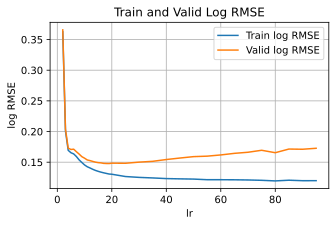

In [38]:
# 学习率设在20-40之间损失最小
train_l_list.clear()
valid_l_list.clear()
x_list = []
for lr in range(2,20,1):
    k,num_epochs,  weight_decay, batch_size = 5,100, 0, 64
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    
    train_l_list.append(train_l)
    valid_l_list.append(valid_l)  
    x_list.append(lr)
    print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')


for lr in range(20,100,5):
    k,num_epochs,  weight_decay, batch_size = 5,100, 0, 64
    train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
    
    train_l_list.append(train_l)
    valid_l_list.append(valid_l)  
    x_list.append(lr)
    print(f'学习率{lr}: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

d2l.plt.figure(figsize=(5, 3))
d2l.plt.plot(x_list, train_l_list[0:], label='Train log RMSE')
d2l.plt.plot(x_list, valid_l_list[0:], label='Valid log RMSE')
d2l.plt.xlabel('lr')
d2l.plt.ylabel('log RMSE')
d2l.plt.legend()
d2l.plt.title('Train and Valid Log RMSE')
d2l.plt.grid(True)
d2l.plt.show()

In [54]:
def evaluate_single_hyperparameter(train_features, train_labels, hyperparam_name, hyperparam_values,):
    train_l_list = []
    valid_l_list = []
    x_list = []
    cnt = 0
    num_epochs=100
    k=5 
    weight_decay=0
    batch_size=64
    for value in hyperparam_values:
        if hyperparam_name == 'lr':
            lr = value
            num_epochs, weight_decay, batch_size = 100, 0.003, 64
        elif hyperparam_name == 'num_epochs':
            num_epochs = value
            lr, weight_decay, batch_size = 25, 0.003, 64
        elif hyperparam_name == 'k':
            k = value
            lr, num_epochs, weight_decay, batch_size = 25, 100, 0.003, 64
        elif hyperparam_name == 'weight_decay':
            weight_decay = value
            lr, num_epochs, batch_size = 25, 100, 64
        elif hyperparam_name == 'batch_size':
            batch_size = value
            lr, num_epochs, weight_decay = 25, 100, 0.003

        train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

        train_l_list.append(train_l)
        valid_l_list.append(valid_l)
        x_list.append(value)
        cnt += 1
        print(f'已经完成第{cnt}组测试...')
        #print(f'{k}-折验证: {hyperparam_name}={value}: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')

    d2l.plt.figure(figsize=(5, 3))
    d2l.plt.plot(x_list, train_l_list, label='Train log RMSE')
    d2l.plt.plot(x_list, valid_l_list, label='Valid log RMSE')
    d2l.plt.xlabel(hyperparam_name)
    d2l.plt.ylabel('log RMSE')
    d2l.plt.legend()
    d2l.plt.title('Train and Valid Log RMSE')
    d2l.plt.grid(True)
    d2l.plt.show()

# 调整超参数的取值范围
#lr_values = list(range(2, 20, 1)) + list(range(20, 100, 5))
#num_epochs_values = [50, 100, 150]
#k_values = [3, 5, 10]

#batch_size_values = [32, 64, 128]

# 逐个测试超参数
# evaluate_single_hyperparameter(train_features, train_labels, 'lr', lr_values)
# evaluate_single_hyperparameter(train_features, train_labels, 'num_epochs', num_epochs_values)
# evaluate_single_hyperparameter(train_features, train_labels, 'k', k_values)

# evaluate_single_hyperparameter(train_features, train_labels, 'batch_size', batch_size_values)


已经完成第1组测试...
已经完成第2组测试...
已经完成第3组测试...
已经完成第4组测试...
已经完成第5组测试...
已经完成第6组测试...
已经完成第7组测试...
已经完成第8组测试...
已经完成第9组测试...
已经完成第10组测试...


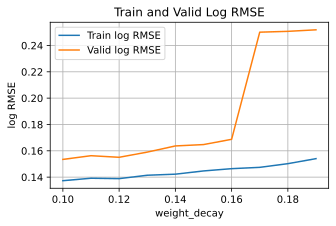

In [41]:
weight_decay_values = np.arange(0.1,0.2,0.01)
evaluate_single_hyperparameter(train_features, train_labels, 'weight_decay', weight_decay_values)

已经完成第1组测试...
已经完成第2组测试...
已经完成第3组测试...
已经完成第4组测试...
已经完成第5组测试...
已经完成第6组测试...
已经完成第7组测试...
已经完成第8组测试...
已经完成第9组测试...
已经完成第10组测试...


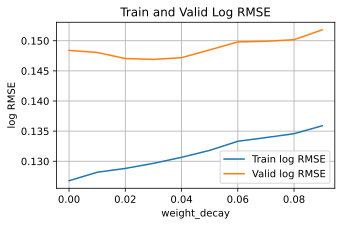

In [42]:
weight_decay_values = np.arange(0,0.1,0.01)
evaluate_single_hyperparameter(train_features, train_labels, 'weight_decay', weight_decay_values)

已经完成第1组测试...
已经完成第2组测试...
已经完成第3组测试...
已经完成第4组测试...
已经完成第5组测试...
已经完成第6组测试...
已经完成第7组测试...


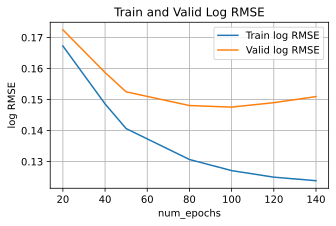

In [61]:
# weight_decay_values = np.arange(0,0.005,0.001)
# evaluate_single_hyperparameter(train_features, train_labels, 'weight_decay', weight_decay_values)
# weight_decay_values取0.003



# batch_size_values = [32,64,128,256,512,1024]
# batch_size_values = np.arange(20,150,20).astype(int)
# print(batch_size_values)

# batch_size_values取40-80左右
# batch_size_values = [20,40,60,80,100,120,140]
# evaluate_single_hyperparameter(train_features, train_labels, 'batch_size', batch_size_values)



num_epochs_values = [20,40,50,80,100,120,140]
evaluate_single_hyperparameter(train_features, train_labels, 'num_epochs', num_epochs_values)

In [62]:
num_epochs = 100
lr = 25
weight_decay = 0.003
batch_size = 80
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.128758


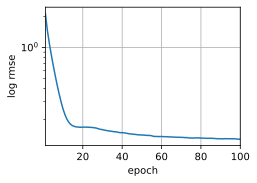

In [65]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)